# prepare data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import warnings

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

# processed data from the source below
# "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
data_path = "dataset_grouped_by_date.csv"

df = pd.read_csv(data_path)

df.rename(columns={'total_price': 'daily_sale',
                  'InvoiceNo': 'unique_invoices',
                  'StockCode': 'unique_stocks',
                  'CustomerID': 'unique_customers'}, inplace=True)

In [2]:
# remove outliers
df = df[df.daily_sale < df.daily_sale.quantile(0.99)]

# adding new features

In [3]:
# calculate 1-week to all-times average ratios (current day excluded)
def one_week_to_all_ratio(signal):
    return ((signal.rolling(7, closed='left').mean()) / (signal.expanding().mean())).fillna(method='ffill').fillna(method='bfill')

df['one_week_to_all_ratio_unique_invoices'] =  one_week_to_all_ratio(df['unique_invoices'])
df['one_week_to_all_ratio_unique_stocks'] =  one_week_to_all_ratio(df['unique_stocks'])
df['one_week_to_all_ratio_unique_customers'] =  one_week_to_all_ratio(df['unique_customers'])
df['one_week_to_all_ratio_sale'] =  one_week_to_all_ratio(df['daily_sale'])

In [4]:
df['day_of_week'] = pd.to_datetime(df.date).dt.weekday

In [5]:
df['day_of_month'] = pd.to_datetime(df.date).dt.day

In [6]:
df['target'] = df['daily_sale']

In [7]:
features_list = ['one_week_to_all_ratio_unique_invoices',
                 'one_week_to_all_ratio_unique_stocks',
                 'one_week_to_all_ratio_unique_customers',
                 'one_week_to_all_ratio_sale',
                 'day_of_week', 'day_of_month']

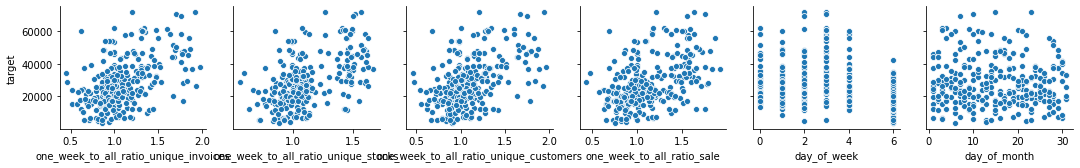

In [8]:
sns.pairplot(df, y_vars="target", x_vars=features_list)

# create multi-feature dataset

In [9]:
train_df = df[df.date < '2011-10-01']
test_df = df[df.date > '2011-11-01']

In [10]:
# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
train_df[features_list] = scaler.fit_transform(train_df[features_list].values.reshape(-1, len(features_list)))
test_df[features_list] = scaler.transform(test_df[features_list].values.reshape(-1,  len(features_list)))

scaler = MinMaxScaler(feature_range=(0, 1))
train_df['target'] = scaler.fit_transform(train_df['target'].values.reshape(-1, 1))
test_df['target'] = scaler.transform(test_df['target'].values.reshape(-1, 1))

In [11]:
trainX, trainY = train_df[features_list].values, train_df['target'].values
testX, testY = test_df[features_list].values, test_df['target'].values

In [12]:
# create and fit the Dense network

def build_model(input_shape=(len(features_list),)):
    model = Sequential()
    model.add(Dense(16, input_shape=input_shape, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='relu'))
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='mean_squared_error', optimizer=opt)

    print(model.summary())

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


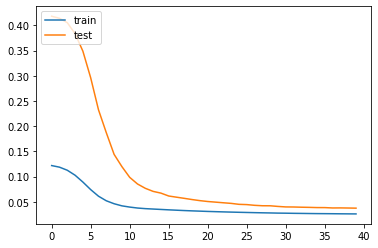

In [13]:
model = build_model()
history = model.fit(trainX, trainY, epochs=40, batch_size=8, verbose=0, validation_data=(testX, testY))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

In [14]:
trainPredict = model.predict(trainX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

<BarContainer object of 20 artists>

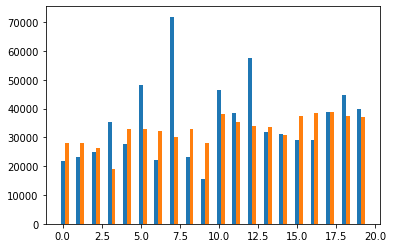

In [15]:
x = np.arange(20)
plt.bar(x, trainY.reshape(-1)[-20:],  width = 0.25)
plt.bar(x+0.25, trainPredict.reshape(-1)[-20:],  width = 0.25)

In [16]:
testPredict = model.predict(testX)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

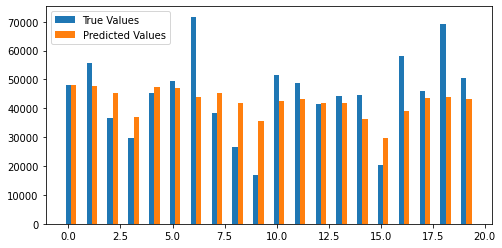

In [17]:
x = np.arange(20)
plt.figure(figsize=(8,4))
plt.bar(x, testY.reshape(-1)[-20:],  width = 0.25)
plt.bar(x+0.25, testPredict.reshape(-1)[-20:],  width = 0.25)
plt.legend(['True Values', 'Predicted Values'])